In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import os

In [197]:
#import dataframe: 
df = pd.read_csv("../data/raw/labeled_ecg.csv",dtype={"label": "str"})

In [198]:
df

,time_sec,ECG,PPG,label
0,0.000,0.008698,0.005493,0
1,0.001,0.008545,0.004883,0
2,0.002,0.008698,0.000610,0
3,0.003,0.008850,0.000305,0
4,0.004,0.008850,0.000610,0
...,...,...,...,...
899996,899.996,-0.016480,0.097961,3
899997,899.997,-0.015717,0.098267,3
899998,899.998,-0.014343,0.097656,3
899999,899.999,-0.012970,0.097656,3


In [199]:
df_subset = df[['time_sec', 'ECG', 'PPG']].copy()
# df_subset = df[['timestamp_ms', 'ECG', 'PPG']].copy()
# Convert to relative time (in seconds)
# df_subset['time'] = (df_subset['timestamp_ms'] - df_subset['timestamp_ms'].iloc[0]) / 1000.0


In [200]:
df_subset

,time_sec,ECG,PPG
0,0.000,0.008698,0.005493
1,0.001,0.008545,0.004883
2,0.002,0.008698,0.000610
3,0.003,0.008850,0.000305
4,0.004,0.008850,0.000610
...,...,...,...
899996,899.996,-0.016480,0.097961
899997,899.997,-0.015717,0.098267
899998,899.998,-0.014343,0.097656
899999,899.999,-0.012970,0.097656


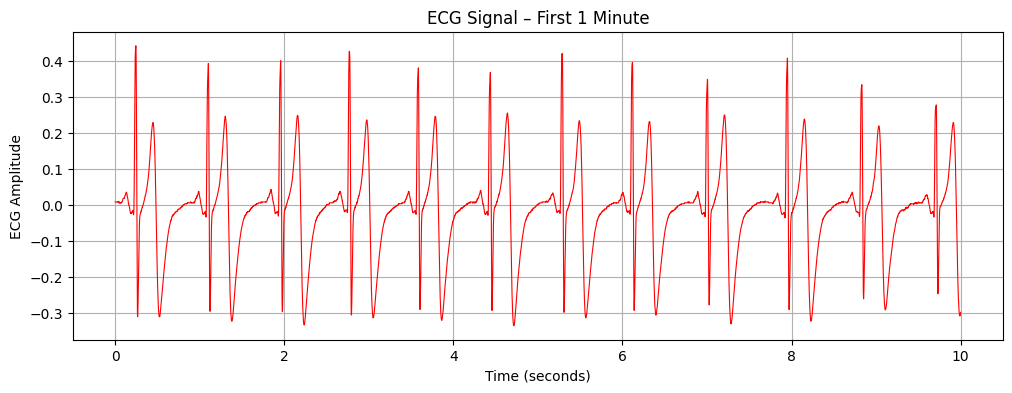

In [201]:
# Visualizing the one  minute ECG waveform
one_minute_df = df_subset[df_subset['time_sec'] <= 10]
plt.figure(figsize=(12, 4))
plt.plot(one_minute_df['time_sec'], one_minute_df['ECG'], color='red', linewidth=0.8)
plt.title("ECG Signal – First 1 Minute")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Amplitude")
plt.grid(True)
plt.show()


In [203]:
import plotly.express as px

fig = px.line(
    one_minute_df,
    x='time_sec',
    y='ECG',
    title='ECG Signal (First 1 Minute)',
    
)
fig.show()


In [204]:
signal = df_subset['ECG'].values
fs = 1000                # sampling rate (Hz)
win_sec = 2
win_len = int(fs * win_sec)
step = win_len
features = []

In [205]:
for start in range(0, len(signal) - win_len, win_len):   # non-overlapping signal
    seg = signal[start:start + win_len]
    mean_ = np.mean(seg)
    var_ = np.var(seg)
    med_ = np.median(seg)
    skew_ = skew(seg)
    kurt_ = kurtosis(seg)
    zcr_ = np.sum(np.diff(np.sign(seg)) != 0) / win_len
    t_mid = df_subset['time'].iloc[start + win_len//2]
    features.append([t_mid, mean_, var_, med_, skew_, kurt_, zcr_])

df_features = pd.DataFrame(features, columns=[
    'time_mid', 'mean', 'variance', 'median', 'skewness', 'kurtosis', 'zcr'
])
df_features.head()


KeyError: 'time'

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#takes all rows and columns from column index 1 to the end. i.e mean until zero crossing rate.
# X scaled = x-mean/sd to the all data features before using kmeans. i.e normalize before feeding into the K Mean
X = StandardScaler().fit_transform(df_features.iloc[:, 1:])
#Create 4 different cluster. 
kmeans = KMeans(n_clusters=4, random_state=42)
df_features['cluster'] = kmeans.fit_predict(X)


In [159]:
df_features

,time_mid,mean,variance,median,skewness,kurtosis,zcr,cluster
0,1.0,0.000219,3.679919e-08,0.000305,-0.235666,0.167280,0.3830,2
1,3.0,0.000228,3.112852e-08,0.000305,-0.107417,0.063204,0.3200,2
2,5.0,0.000333,5.633476e-08,0.000305,0.608478,0.849265,0.1920,2
3,7.0,0.000307,3.764642e-08,0.000305,0.216190,-0.022511,0.2020,2
4,9.0,0.000242,3.255980e-08,0.000305,-0.022918,0.097817,0.2945,2
...,...,...,...,...,...,...,...,...
1829,3659.0,-0.015433,6.963208e-03,-0.010834,2.386446,15.142762,0.0170,0
1830,3661.0,-0.012757,1.196562e-02,-0.015793,1.409833,6.768246,0.0115,3
1831,3663.0,-0.020724,1.508568e-02,-0.022659,0.827808,3.097193,0.0305,3
1832,3665.0,-0.007206,1.117182e-02,-0.011597,2.369863,11.913678,0.0145,0


In [165]:
from sklearn.metrics import silhouette_score

for k in range(2, 18):
    kmeans_k = KMeans(n_clusters=k, random_state=42)
    labels_k = kmeans_k.fit_predict(X)
    sil_k = silhouette_score(X, labels_k)
    print(f"k = {k}, silhouette = {sil_k:.3f}")


k = 2, silhouette = 0.610
k = 3, silhouette = 0.609
k = 4, silhouette = 0.592
k = 5, silhouette = 0.573
k = 6, silhouette = 0.574
k = 7, silhouette = 0.523
k = 8, silhouette = 0.312
k = 9, silhouette = 0.315
k = 10, silhouette = 0.310
k = 11, silhouette = 0.310
k = 12, silhouette = 0.216
k = 13, silhouette = 0.217
k = 14, silhouette = 0.216
k = 15, silhouette = 0.229
k = 16, silhouette = 0.228
k = 17, silhouette = 0.234


In [160]:
df_features = df_features.copy()
df_features['start_idx'] = df_features.index * step
df_features['end_idx']   = df_features['start_idx'] + win_len


In [166]:
import numpy as np

signal = df_subset['ECG'].values
time   = df_subset['time'].values

cluster_id = 1
N = len(signal)

mask = np.zeros(N, dtype=bool)

for _, row in df_features[df_features['cluster'] == cluster_id].iterrows():
    s = int(row.start_idx)
    e = int(row.end_idx)
    mask[s:e] = True

# ECG samples belonging to this cluster
cluster_signal = np.where(mask, signal, np.nan)


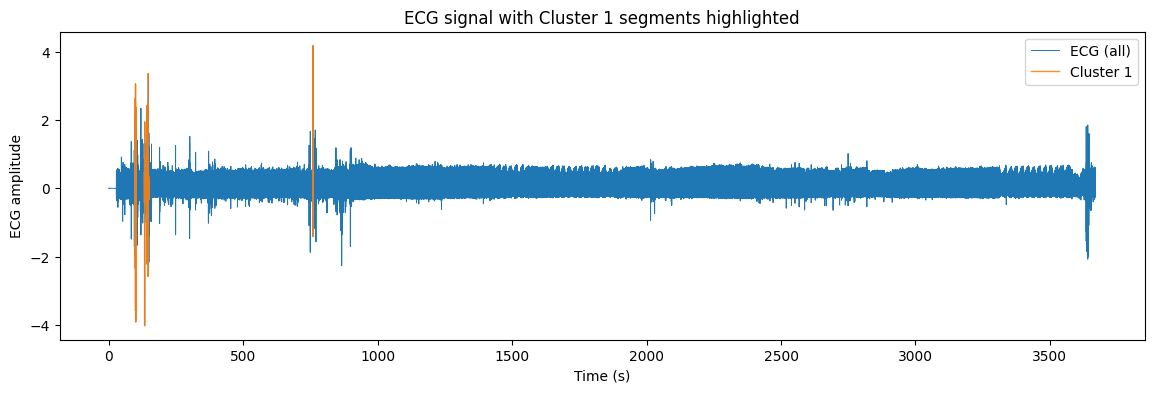

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(time, signal, linewidth=0.7, label='ECG (all)')
plt.plot(time, cluster_signal, linewidth=1.0, label=f'Cluster {cluster_id}', alpha=0.9)

plt.xlabel("Time (s)")
plt.ylabel("ECG amplitude")
plt.title(f"ECG signal with Cluster {cluster_id} segments highlighted")
plt.legend()
#path to save figure. 
save_dir = "../reports/figures"
# build file name
file_name = f"ecg_cluster_{cluster_id}.png"
save_path = os.path.join(save_dir, file_name)
# --- save figure ---
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # high-res export

plt.show()


In [145]:
cluster_id = 4
cluster_windows = df_features[df_features['cluster'] == cluster_id].head(2)  # first 6 windows

rows = len(cluster_windows)
plt.figure(figsize=(12, 2.5 * rows))

for i, (_, row) in enumerate(cluster_windows.iterrows(), start=1):
    s = int(row.start_idx)
    e = int(row.end_idx)
    seg_t = time[s:e]
    seg_x = signal[s:e]

    plt.subplot(rows, 1, i)
    plt.plot(seg_t, seg_x, color='orange', linewidth=0.8)
    plt.title(f"Cluster {cluster_id} – window {int(row.name)} (t ≈ {row.time_mid:.1f}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("ECG")

plt.tight_layout()
filename_window = f"ecg_window_{cluster_id}.png"
save_path = os.path.join(save_dir, filename_window)
# --- save figure ---
plt.savefig(save_path, dpi=300, bbox_inches='tight')  
plt.show()


/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/matplotlib/patches.py:797: RuntimeWarning:

invalid value encountered in scalar add

/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/matplotlib/transforms.py:2037: RuntimeWarning:

invalid value encountered in scalar add

/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/matplotlib/transforms.py:2437: RuntimeWarning:

invalid value encountered in dot



<Figure size 1200x0 with 0 Axes>

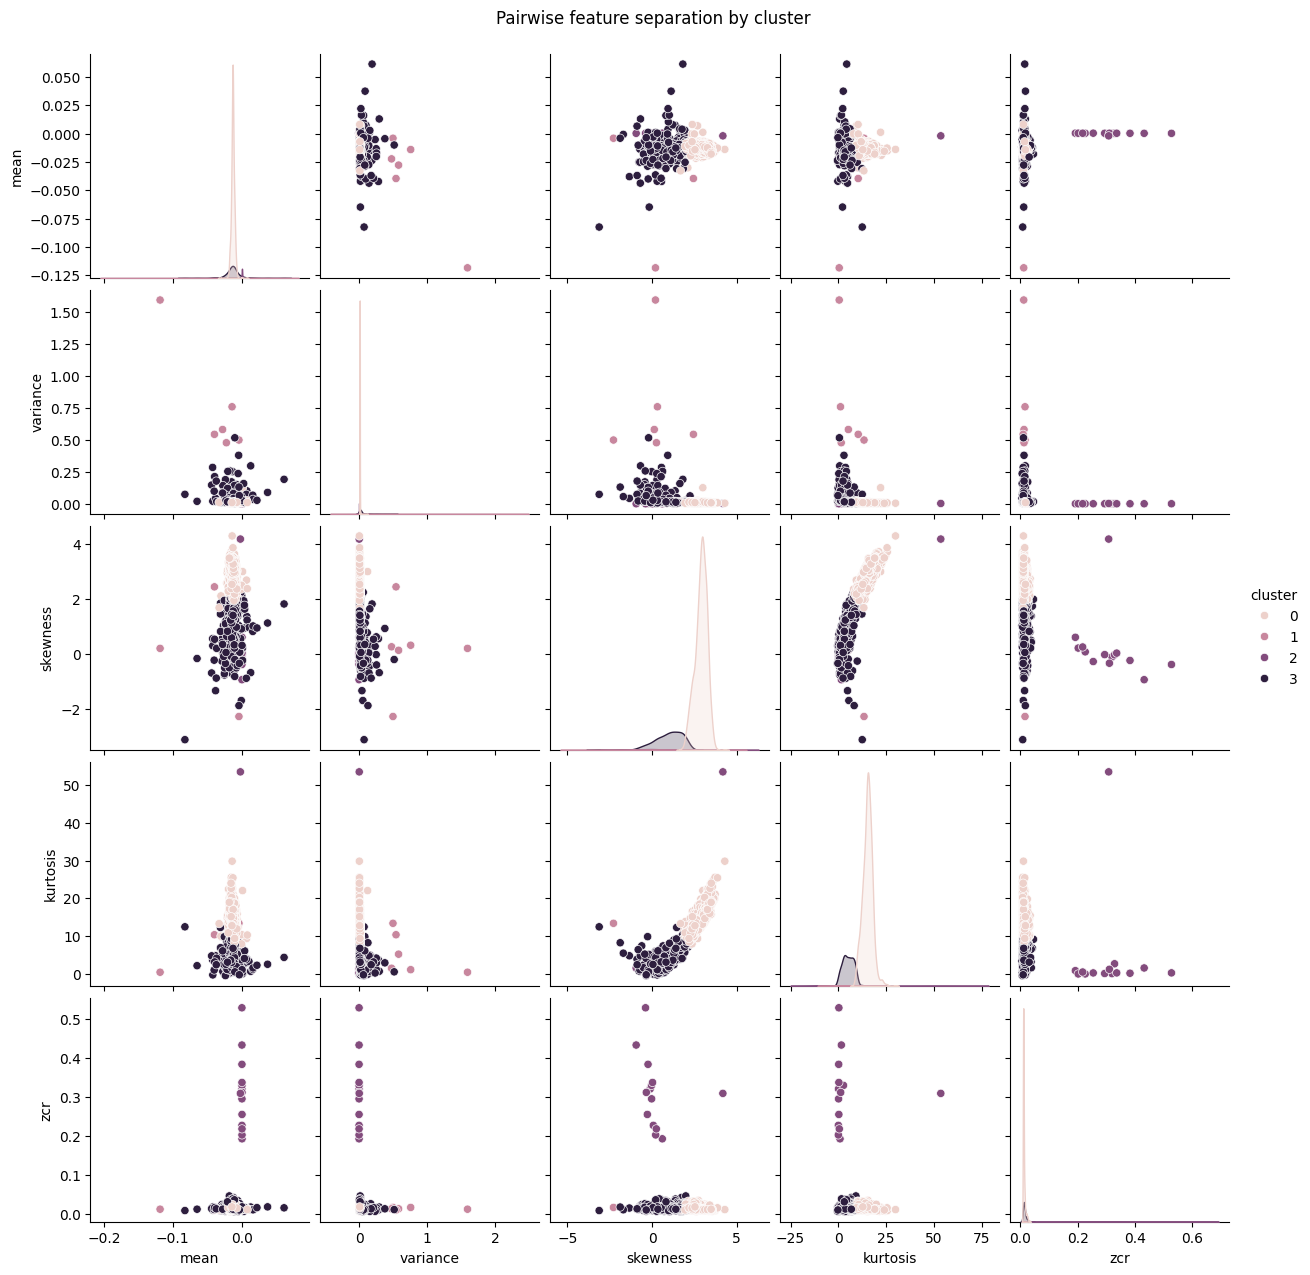

In [168]:
import seaborn as sns

sns.pairplot(df_features, vars=['mean','variance','skewness','kurtosis','zcr'], hue='cluster', diag_kind='kde')
plt.suptitle("Pairwise feature separation by cluster", y=1.02)
plt.show()


Explained variance ratio: [0.37484115 0.30642006]


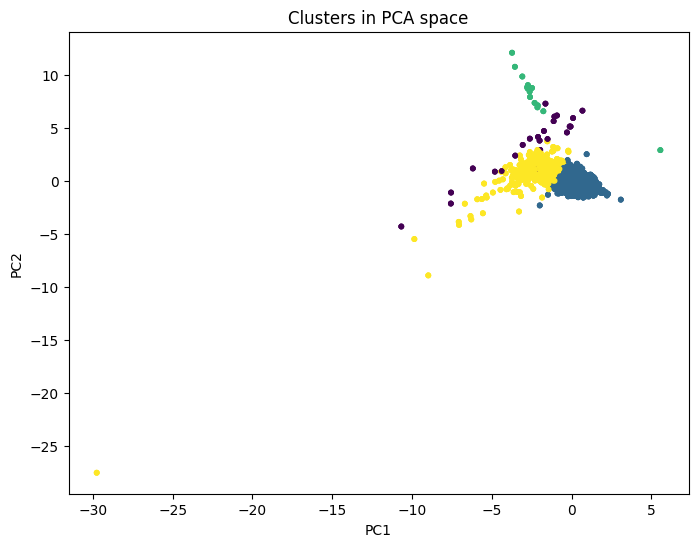

,PC1,PC2
mean,0.268309,0.495264
variance,-0.461509,-0.264755
median,0.344954,0.506393
skewness,0.546340,-0.360459
kurtosis,0.535232,-0.353108
zcr,-0.105192,0.416616


In [132]:
from sklearn.decomposition import PCA
#PCA finds the direction of maximum variance in the data(principal components) and keeps the first two directions. 
pca = PCA(n_components=2)
#Standarized features.
X_scaled = StandardScaler().fit_transform(df_features[['mean','variance','median','skewness','kurtosis','zcr']])
pca_result = pca.fit_transform(X_scaled)
#Gives output how much of the total variance each PC captures. In our case it captured 80 % of variation
print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df_features['cluster'], cmap='viridis', s=10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters in PCA space')
plt.show()

# Feature loadings (importance of each original feature in PC axes)
loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1','PC2'], 
                        index=['mean','variance','median','skewness','kurtosis','zcr'])
loadings


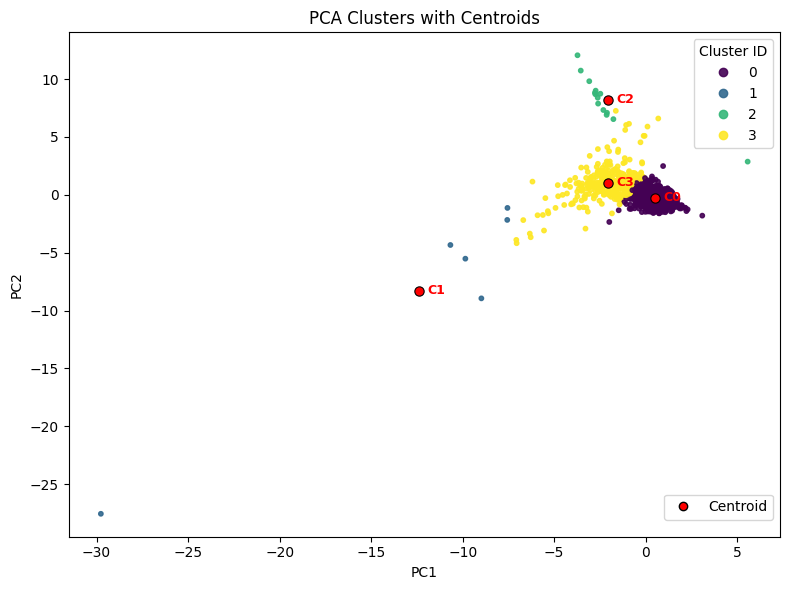

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# --- features & labels ---
feature_cols = ['mean','variance','median','skewness','kurtosis','zcr']
labels = df_features['cluster'].values
clusters = np.unique(labels)

# --- scale + PCA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features[feature_cols])

pca = PCA(n_components=2, random_state=42)
scores = pca.fit_transform(X_scaled)

# --- centroid in PCA space ---
centroids_2d = np.vstack([scores[labels == k].mean(axis=0) for k in clusters])

# --- scatter of cluster points ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(scores[:,0], scores[:,1],
                      c=labels, cmap='viridis', s=10, alpha=0.9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Clusters with Centroids')

# --- red circular centroids ---
plt.scatter(centroids_2d[:,0], centroids_2d[:,1],
            s=45, color='red', edgecolors='black', linewidths=0.8)

# --- label centroids slightly to the right ---
for k, (x, y) in zip(clusters, centroids_2d):
    plt.annotate(f"C{k}",
                 xy=(x, y),
                 xytext=(6, 0),              # shift right 6 points
                 textcoords='offset points',
                 fontsize=9, fontweight='bold',
                 color='red', va='center')

# --- cluster color legend (upper right) ---
cluster_handles, _ = scatter.legend_elements()
cluster_legend = plt.legend(cluster_handles,
                            [f"{i}" for i in np.unique(labels)],
                            title="Cluster ID",
                            loc="upper right")
plt.gca().add_artist(cluster_legend)

# --- centroid legend (bottom-right with padding) ---
centroid_handle = Line2D([0], [0], marker='o', color='w',
                         markerfacecolor='red', markeredgecolor='black',
                         markersize=6, linewidth=0, label='Centroid')

plt.legend(handles=[centroid_handle],
           loc='lower right',
           bbox_to_anchor=(1.0, 0.02),   # bottom-right, 20+ point padding below
           frameon=True, ncol=1)

plt.tight_layout()
filename_PCA = f"PCA_.png"
save_path = os.path.join(save_dir, filename_PCA)
# --- save figure ---
plt.savefig(save_path, dpi=300, bbox_inches='tight')  
plt.show()


In [170]:
# Feature loadings (importance of each original feature in each principal component)
loadings = pd.DataFrame(
    pca.components_.T,                  # transpose to align features as rows
    columns=['PC1', 'PC2'],             # each column = one principal component
    index=feature_cols                  # feature names as row index
)

loadings


,PC1,PC2
mean,0.268309,0.495264
variance,-0.461509,-0.264755
median,0.344954,0.506393
skewness,0.546340,-0.360459
kurtosis,0.535232,-0.353108
zcr,-0.105192,0.416616


In [ ]:
#Hierarchiacal clustering ECG 


In [171]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Select feature matrix
X = StandardScaler().fit_transform(df_features.iloc[:, 1:])  # skip time_mid

# Try hierarchical clustering
agg = AgglomerativeClustering(
    n_clusters=3,
    linkage='ward'
)

labels_agg = agg.fit_predict(X)
df_features['cluster_hier'] = labels_agg

# Evaluate silhouette
sil_agg = silhouette_score(X, labels_agg)
print("Hierarchical Silhouette:", sil_agg)


Hierarchical Silhouette: 0.5482395017417655


In [172]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)   # keep 90% variance
X_pca = pca.fit_transform(X)

agg = AgglomerativeClustering(
    n_clusters=3,
    linkage='ward'
)

labels_agg = agg.fit_predict(X_pca)
df_features['cluster_hier'] = labels_agg

print("Hierarchical silhouette:", silhouette_score(X_pca, labels_agg))


Hierarchical silhouette: 0.38477661799167084


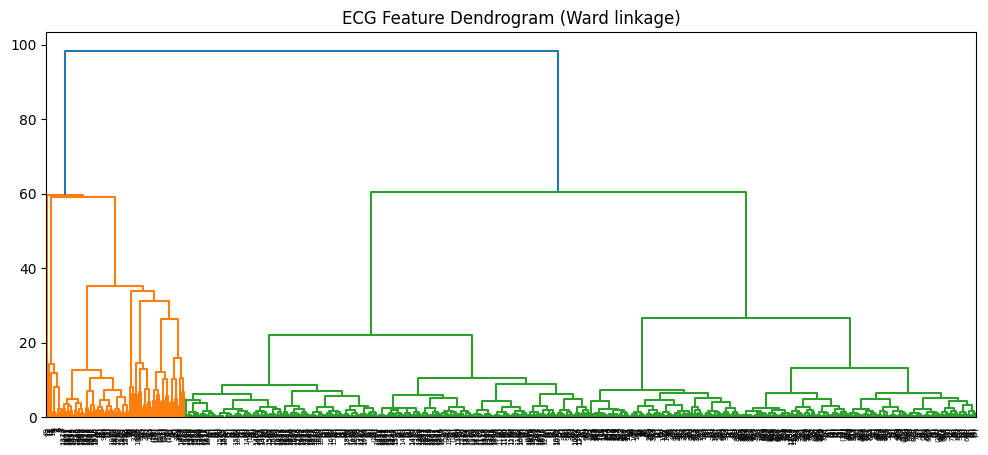

In [173]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(X_pca, method='ward')

plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='level', p=10)
plt.title("ECG Feature Dendrogram (Ward linkage)")
plt.show()


In [174]:
sil_kmeans = silhouette_score(X, kmeans.labels_)
sil_hier = silhouette_score(X, labels_agg)

print("K-means silhouette:", sil_kmeans)
print("Hierarchical silhouette:", sil_hier)


K-means silhouette: 0.5448024775633566
Hierarchical silhouette: 0.34624669944019876
